In [8]:


import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import Dense,Flatten, BatchNormalization, Dropout, GlobalMaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model
from tensorflow.keras.applications import VGG16
from keras.models import Sequential
from tensorflow.keras.losses import CategoricalCrossentropy


from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import classification_report
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc

In [3]:
# Load the augmented data from the saved file
data = np.load('../data/external/coral_augmented_combined.npz')

# Access the arrays from the loaded data
X_train = data['X_train']
y_train = data['y_train']
X_test = data['X_test']
y_test = data['y_test']
X_valid = data['X_valid']
y_valid = data['y_valid']

# Print the shapes to verify
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_valid shape: {X_valid.shape}")
print(f"y_valid shape: {y_valid.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (4600, 224, 224, 3)
y_train shape: (4600,)
X_valid shape: (1152, 224, 224, 3)
y_valid shape: (1152,)
X_test shape: (1440, 224, 224, 3)
y_test shape: (1440,)


In [4]:
# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the labels in both training and test sets
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)
y_valid_encoded = label_encoder.transform(y_valid)

# Convert the encoded labels to one-hot encoded format
num_classes = len(label_encoder.classes_)
y_train_onehot = to_categorical(y_train_encoded, num_classes=num_classes)
y_test_onehot = to_categorical(y_test_encoded, num_classes=num_classes)
y_valid_onehot = to_categorical(y_valid_encoded, num_classes=num_classes)

In [9]:
# Initialize VGG16 with pre-trained weights (you can include or exclude top layers)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Create a new model on top of the VGG16 base
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), 
              loss=CategoricalCrossentropy(),
              metrics=['accuracy'])

# You can print a summary of the model's architecture
model.summary()

# Train the model
history = model.fit(X_train, y_train_onehot, 
                    validation_data=(X_valid, y_valid_onehot), 
                    batch_size=32, 
                    epochs=10)


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dense_2 (Dense)             (None, 16)                401424    
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense_3 (Dense)             (None, 2)                 34        
                                                                 
Total params: 15,116,146
Trainable params: 15,116,146
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
144/144 [======================

In [10]:
model.save('../models/coral_vgg16.h5')

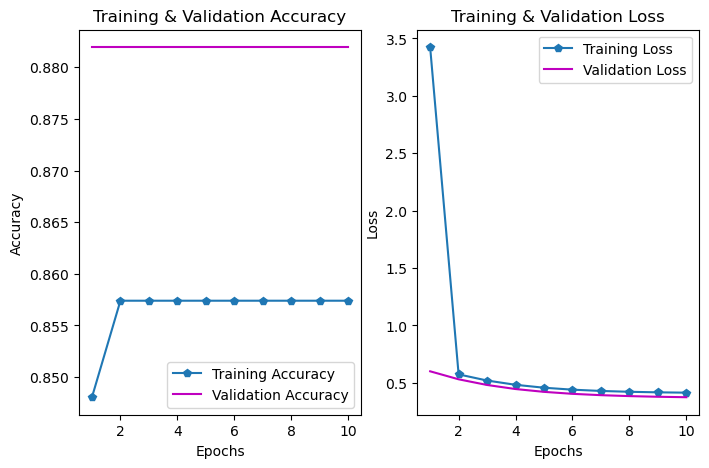

In [11]:
# Assuming you have already trained your model and have the `history` object
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(8, 5)

# Extract training and validation accuracy from the history object
epochs = range(1, len(history.history['accuracy']) + 1)
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Plot training and validation accuracy with purple markers and solid line
ax[0].plot(epochs, train_acc, 'p-', label='Training Accuracy')
ax[0].plot(epochs, val_acc, 'm-', label='Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

# Extract training and validation loss from the history object
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot training and validation loss with purple markers and solid line
ax[1].plot(epochs, train_loss, 'p-', label='Training Loss')
ax[1].plot(epochs, val_loss, 'm-', label='Validation Loss')
ax[1].set_title('Training & Validation Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")

plt.show()


In [12]:
# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(X_test, y_test_onehot)
print(f"Test Accuracy: {test_accuracy}")

45/45 [==============================] - 185s 4s/step - loss: 0.3460 - accuracy: 0.9000
Test Accuracy: 0.8999999761581421


In [13]:
# Evaluate the model on the test data
accuracy = model.evaluate(X_test, y_test_onehot)[1]  # Index 1 corresponds to accuracy
print("Accuracy of the model is:", accuracy * 100, "%")

# You can also calculate other evaluation metrics, such as precision, recall, and F1-score.
from sklearn.metrics import classification_report

# Get model predictions
y_pred = model.predict(X_test)

# Convert one-hot encoded labels back to class labels
y_test_class = label_encoder.inverse_transform(np.argmax(y_test_onehot, axis=1))
y_pred_class = label_encoder.inverse_transform(np.argmax(y_pred, axis=1))

cohen_kappa = cohen_kappa_score(y_test_class, y_pred_class)

# Generate a classification report
report = classification_report(y_test_class, y_pred_class)

print("Cohen's Kappa:", cohen_kappa)
print("Classification Report:")
print(report)


45/45 [==============================] - 187s 4s/step - loss: 0.3460 - accuracy: 0.9000
Accuracy of the model is: 89.99999761581421 %
45/45 [==============================] - 186s 4s/step
Cohen's Kappa: 0.0
Classification Report:
                precision    recall  f1-score   support

          apal       0.00      0.00      0.00       144
pseudodiploria       0.90      1.00      0.95      1296

      accuracy                           0.90      1440
     macro avg       0.45      0.50      0.47      1440
  weighted avg       0.81      0.90      0.85      1440



/Users/sumaiyauddin/opt/anaconda3/envs/tensorflow_tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/sumaiyauddin/opt/anaconda3/envs/tensorflow_tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/sumaiyauddin/opt/anaconda3/envs/tensorflow_tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavi